In [413]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lifelines import CoxPHFitter
from lifelines.utils import datetimes_to_durations
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',300,\
              'display.max_rows',300, \
                'display.max_colwidth',None,\
                    'display.expand_frame_repr', False\
                        )
warnings.filterwarnings("ignore")

EDA

In [414]:
# read raw df
raw=pd.read_csv('../Wealthfront/Data/loan_data.csv')
raw.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,72804.0,Current,credit_card,MA,16.73,0.0,1995-12-27 02:06:00,NaN,21.0,8751.0,49.0,13263.18,7273.77,4736.82,2536.95,NaN,NaN,10.16%,NaN,NaN,10.16
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,100000.0,Current,small_business,WA,9.10,0.0,1994-04-07 12:00:00,NaN,16.0,20650.0,45.0,15294.25,496.78,380.75,116.03,NaN,NaN,8.90%,NaN,NaN,8.90
2,784712,16500,16500,60 months,7.90,333.78,2 years,MORTGAGE,42000.0,Late (31-120 days),small_business,NY,10.43,0.0,1993-07-16 08:41:00,NaN,9.0,2229.0,17.0,12966.64,5000.85,3533.36,1467.49,NaN,NaN,7.90%,NaN,NaN,7.90
3,843448,5500,5500,36 months,13.67,187.10,3 years,RENT,55000.0,Fully Paid,debt_consolidation,NJ,20.71,0.0,1987-07-24 12:40:00,NaN,17.0,9486.0,25.0,0.00,5792.14,5500.00,292.14,NaN,NaN,13.67%,NaN,NaN,13.67
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,34000.0,Current,debt_consolidation,VA,32.40,0.0,1998-03-15 06:57:00,47.0,6.0,4915.0,15.0,4430.59,2912.26,1969.41,942.85,NaN,NaN,15.80%,NaN,NaN,15.80


In [416]:
# check missing values
raw.isna().sum()

# loan status is the main determining variable, so I will dropna records for missing that value
df=raw.copy()
df.dropna(subset='term',inplace=True)

# drop cols for na and duplicates
df.drop(columns=['wtd_loans','interest_rate','num_rate','numrate','int_rate2','int_rate3','total_rec_prncp','total_rec_int'],inplace=True)

# adjust dtypes for some cols and feature engineering
df['term']=df['term'].str.split(' ').str[1].apply(int)
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['earliest_cr_line']=( datetime.now()- df['earliest_cr_line']).dt.days/365.25

# fillna for delinq and add a col as delinq indicator
df['mths_since_last_delinq'].fillna(-1,inplace=True)
df['delinquent_indicator'] = (df['mths_since_last_delinq'] >= 0).astype(int)

# one hot encoding for categorical cols
df = pd.get_dummies(df, columns=['home_ownership'], prefix='home_ownership')
df = pd.get_dummies(df, columns=['purpose'], prefix='loan_purpose')
df.replace({True:1,False:0},inplace=True)

# create an address state dic and label state as its currency
state_counts_dic=df['addr_state'].value_counts().to_dict()
df['addr_state'] = df['addr_state'].map(state_counts_dic)

# label emp_length as numeric value
df['emp_length']=df['emp_length']\
    .replace({'10+ years': 11,'< 1 year': 0})\
        .apply(lambda x: int(x.split(' ')[0]) if isinstance(x,str) else x)

# add a duration col to track current duration of loan
df['loan_complete_rate']=round(df['total_pymnt']/(df['installment']*df['term']),4)

# map loan status to censoring
censor_mapping = {
    'Current': 0,           
    'Late (31-120 days)': 1, 
    'Fully Paid': 1,        
    'Charged Off': 1,        
    'Late (16-30 days)': 1, 
    'In Grace Period': 0,    
    'Default': 1              
}

df['censor_status'] = df['loan_status'].map(censor_mapping)

# map severity based on loan status

severity_weights = {
    'Fully Paid': 1,
    'Late (16-30 days)': 0.75,
    'Late (31-120 days)': 0.65,
    'Charged Off': 0.6,
    'Default':0.5,
    'Current': 0, 
    'In Grace Period': 0
}

df['severity_rate']=df['loan_status'].map(severity_weights)

# emp_length KNN impute
data_to_impute = df[['emp_length']]
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(data_to_impute)
df['emp_length']=imputed_data[:, 0]

# set a ref df
df2=df.drop(columns=['id','loan_status','loan_amnt','funded_amnt','out_prncp','severity_rate'])



df.head()


,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,delinquent_indicator,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_purpose_car,loan_purpose_credit_card,loan_purpose_debt_consolidation,loan_purpose_home_improvement,loan_purpose_house,loan_purpose_major_purchase,loan_purpose_medical,loan_purpose_moving,loan_purpose_other,loan_purpose_renewable_energy,loan_purpose_small_business,loan_purpose_vacation,loan_purpose_wedding,loan_complete_rate,censor_status,severity_rate
0,571203,18000,18000,60,10.16,383.87,11.0,72804.0,Current,177,16.73,0.0,27.986311,-1.0,21.0,8751.0,49.0,13263.18,7273.77,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.3158,0,0.00
1,694891,15675,15675,36,8.90,497.74,11.0,100000.0,Current,228,9.10,0.0,29.708419,-1.0,16.0,20650.0,45.0,15294.25,496.78,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0277,0,0.00
2,784712,16500,16500,60,7.90,333.78,2.0,42000.0,Late (31-120 days),822,10.43,0.0,30.433949,-1.0,9.0,2229.0,17.0,12966.64,5000.85,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.2497,1,0.65
3,843448,5500,5500,36,13.67,187.10,3.0,55000.0,Fully Paid,390,20.71,0.0,36.413415,-1.0,17.0,9486.0,25.0,0.00,5792.14,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.8599,1,1.00
4,974654,6400,6400,36,15.80,224.38,2.0,34000.0,Current,302,32.40,0.0,25.771389,47.0,6.0,4915.0,15.0,4430.59,2912.26,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.3605,0,0.00


In [417]:
print(df['emp_length'].unique())

[11.          2.          3.          7.          6.          4.
  5.          8.          6.38787148  1.          0.          9.        ]


Cox Proportional Hazards model

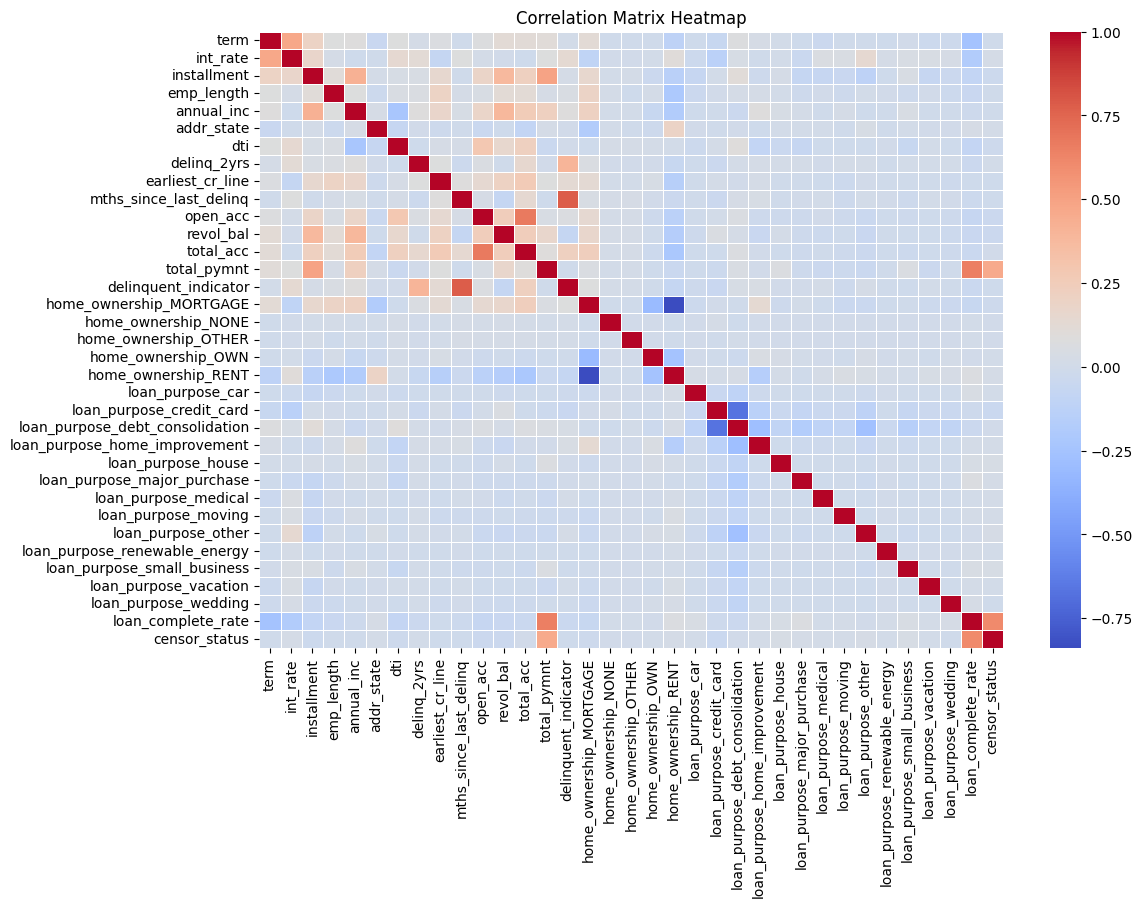

In [418]:
# check for collinearity
correlation_matrix = df2.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [420]:
# Modeling
train_df, val_df = train_test_split(df2, test_size=0.2, random_state=42)
cph = CoxPHFitter(penalizer=1.0)
cph.fit(train_df, duration_col='loan_complete_rate', event_col='censor_status')

# test the model on val_df
predicted_scores = cph.predict_partial_hazard(val_df)
val_cindex = concordance_index(val_df['loan_complete_rate'], -predicted_scores, val_df['censor_status'])
print("Validation C-index: {:.3f}".format(val_cindex))

Validation C-index: 0.722


In [421]:
# make prediction of loan complete rate for censored group
result_df=df2.query('censor_status==0')
result_df['predicted_loan_complete_rate']=cph.predict_expectation(result_df)
valid_df=df2.query('censor_status==1')
valid_df['predicted_loan_complete_rate']=cph.predict_expectation(valid_df)

result_df.head()

,term,int_rate,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,total_pymnt,delinquent_indicator,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_purpose_car,loan_purpose_credit_card,loan_purpose_debt_consolidation,loan_purpose_home_improvement,loan_purpose_house,loan_purpose_major_purchase,loan_purpose_medical,loan_purpose_moving,loan_purpose_other,loan_purpose_renewable_energy,loan_purpose_small_business,loan_purpose_vacation,loan_purpose_wedding,loan_complete_rate,censor_status,predicted_loan_complete_rate
0,60,10.16,383.87,11.0,72804.0,177,16.73,0.0,27.986311,-1.0,21.0,8751.0,49.0,7273.77,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.3158,0,0.791502
1,36,8.90,497.74,11.0,100000.0,228,9.10,0.0,29.708419,-1.0,16.0,20650.0,45.0,496.78,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0277,0,0.804281
4,36,15.80,224.38,2.0,34000.0,302,32.40,0.0,25.771389,47.0,6.0,4915.0,15.0,2912.26,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.3605,0,0.785796
6,36,7.51,194.45,7.0,33600.0,1603,18.05,0.0,18.357290,-1.0,7.0,5174.0,10.0,4847.25,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.6924,0,0.807432
7,36,13.49,247.70,3.0,50000.0,616,19.06,0.0,17.965777,-1.0,8.0,12026.0,13.0,6185.50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.6937,0,0.796725


Regression for Severity Rate

In [422]:
# tailor the feature used in CPH
df_regre_train=df.query('censor_status==1').drop(columns=['id','loan_status','total_pymnt',\
                                                          'loan_status','out_prncp','total_pymnt',\
                                                            'loan_complete_rate','censor_status'\
                                                               ])

In [423]:
# split the dataset into features and the severity
X_regre_train = df_regre_train.drop('severity_rate', axis=1)
y_regre_train = df_regre_train['severity_rate']

# create a k-fold cross-validation object
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# define the custom scorer for regression
scorer = make_scorer(mean_squared_error)

In [424]:
## model performance comparison

# models
knn_regressor = KNeighborsRegressor()
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
svm_regressor = SVR()
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)

# list of models for comparison
models = [knn_regressor, rf_regressor, svm_regressor, xgb_regressor]
model_names = ['KNN', 'Random Forest', 'SVM', 'XGBoost']

for model, model_name in zip(models, model_names):
    # Train and evaluate the model with k-fold cross-validation
    cv_scores = cross_val_score(model, X_regre_train, y_regre_train, cv=kfold, scoring='neg_mean_squared_error')

    # Display scores for each fold
    for i, score in enumerate(cv_scores, start=1):
        print(f"{model_name} - Fold {i}: {score:.4f}")

    # Display mean score
    print(f"{model_name} - Mean Score: {np.mean(cv_scores):.4f}")
    print("\n")


for model, model_name in zip(models, model_names):
    # drain and evaluate the model with k-fold cross-validation
    mse_scores = -cross_val_score(model, X_regre_train, y_regre_train, cv=kfold, scoring='neg_mean_squared_error')

    # display mean MSE score
    print(f"{model_name} - Mean MSE: {np.mean(mse_scores):.4f}\n")


KNN - Fold 1: -0.0361
KNN - Fold 2: -0.0379
KNN - Fold 3: -0.0335
KNN - Fold 4: -0.0385
KNN - Fold 5: -0.0334
KNN - Mean Score: -0.0359


Random Forest - Fold 1: -0.0291
Random Forest - Fold 2: -0.0314
Random Forest - Fold 3: -0.0252
Random Forest - Fold 4: -0.0319
Random Forest - Fold 5: -0.0278
Random Forest - Mean Score: -0.0291


SVM - Fold 1: -0.0320
SVM - Fold 2: -0.0313
SVM - Fold 3: -0.0270
SVM - Fold 4: -0.0336
SVM - Fold 5: -0.0292
SVM - Mean Score: -0.0306


XGBoost - Fold 1: -0.0335
XGBoost - Fold 2: -0.0361
XGBoost - Fold 3: -0.0308
XGBoost - Fold 4: -0.0365
XGBoost - Fold 5: -0.0334
XGBoost - Mean Score: -0.0340


KNN - Mean MSE: 0.0359

Random Forest - Mean MSE: 0.0291

SVM - Mean MSE: 0.0306

XGBoost - Mean MSE: 0.0340



In [425]:
## use RF to predict the severity rate for censored group
rf_regressor.fit(X_regre_train, y_regre_train)

result_df2=df_regre_train=df.query('censor_status==0').drop(columns=['id','loan_status','total_pymnt',\
                                                          'loan_status','out_prncp','total_pymnt',\
                                                            'loan_complete_rate','censor_status',\
                                                               'severity_rate'])
result_df2['predicted_severity_rate']=rf_regressor.predict(result_df2)
valid_df2=X_regre_train.copy()
valid_df2['predicted_severity_rate']=rf_regressor.predict(valid_df2)


Combining results of two models

In [426]:
# edit valid table
merged_valid=df[['id','loan_complete_rate','censor_status','severity_rate']].query('censor_status==1')
merged_valid=pd.concat([merged_valid,valid_df['predicted_loan_complete_rate'].to_frame()],axis=1)
merged_valid=pd.concat([merged_valid,valid_df2['predicted_severity_rate'].to_frame()],axis=1)
merged_valid['combined_score']=merged_valid['predicted_loan_complete_rate']*merged_valid['predicted_severity_rate']

## normalize the score
def min_max_scaling(x, x_min, x_max, new_min, new_max):
    return (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min
# define the ranges
original_range_min = merged_valid['combined_score'].min()
original_range_max = merged_valid['combined_score'].max()
new_range_min = 0.5
new_range_max = 1
merged_valid['combined_score_normalized'] = merged_valid['combined_score']\
    .apply(lambda x: min_max_scaling(x, original_range_min, original_range_max, new_range_min, new_range_max))

# calculate mse for normalized score
mse2 = mean_squared_error(merged_valid['severity_rate'], merged_valid['combined_score_normalized'])
print(f'Mean Squared Error of combined result: {mse2:.4f}')


Mean Squared Error of combined result: 0.0052


In [427]:
merged_valid.head()

,id,loan_complete_rate,censor_status,severity_rate,predicted_loan_complete_rate,predicted_severity_rate,combined_score,combined_score_normalized
2,784712,0.2497,1,0.65,0.797044,0.6875,0.547968,0.662688
3,843448,0.8599,1,1.00,0.795094,0.9380,0.745798,0.912494
5,1023119,0.9527,1,1.00,0.793490,0.9260,0.734772,0.898571
9,1063649,0.1665,1,0.60,0.763322,0.6980,0.532799,0.643533
13,1071862,0.9461,1,1.00,0.812530,0.9860,0.801155,0.982394


In [428]:
# edit result table
merged_result=df[['id','loan_complete_rate','censor_status']].query('censor_status==0')
merged_result=pd.concat([merged_result,result_df['predicted_loan_complete_rate'].to_frame()],axis=1)
merged_result=pd.concat([merged_result,result_df2['predicted_severity_rate'].to_frame()],axis=1)
merged_result['combined_score']=merged_result['predicted_loan_complete_rate']*merged_result['predicted_severity_rate']

## normalize the score
def min_max_scaling(x, x_min, x_max, new_min, new_max):
    return (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min
# define the ranges
original_range_min = merged_result['combined_score'].min()
original_range_max = merged_result['combined_score'].max()
new_range_min = 0.5
new_range_max = 1
merged_result['combined_score_normalized'] = merged_result['combined_score']\
    .apply(lambda x: min_max_scaling(x, original_range_min, original_range_max, new_range_min, new_range_max))

# predict censored loan "good" or "bad" based on two models
merged_result['good or bad']=np.where(merged_result['combined_score_normalized']>0.75,"good","bad")


In [429]:
merged_valid.head()

,id,loan_complete_rate,censor_status,severity_rate,predicted_loan_complete_rate,predicted_severity_rate,combined_score,combined_score_normalized
2,784712,0.2497,1,0.65,0.797044,0.6875,0.547968,0.662688
3,843448,0.8599,1,1.00,0.795094,0.9380,0.745798,0.912494
5,1023119,0.9527,1,1.00,0.793490,0.9260,0.734772,0.898571
9,1063649,0.1665,1,0.60,0.763322,0.6980,0.532799,0.643533
13,1071862,0.9461,1,1.00,0.812530,0.9860,0.801155,0.982394


In [430]:
merged_result['good or bad'].value_counts()

good or bad
good    6203
bad     1967
Name: count, dtype: int64

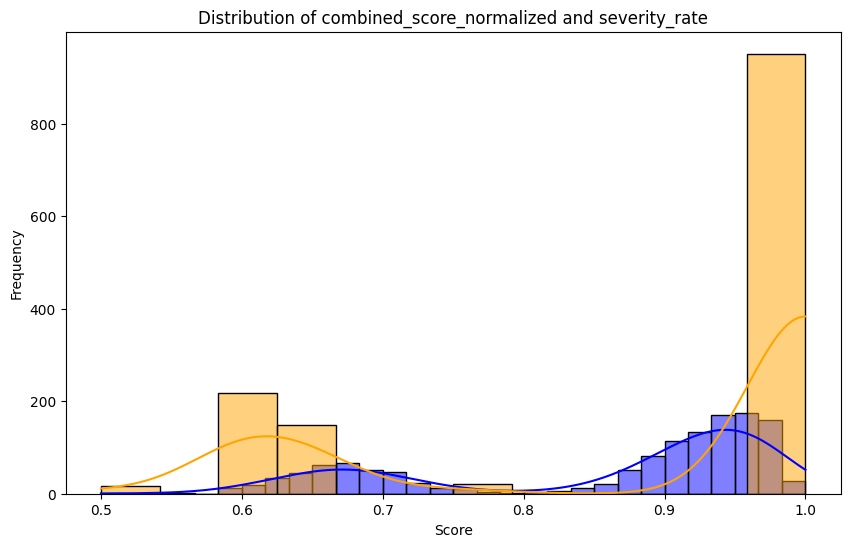

In [431]:
# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(merged_valid['combined_score_normalized'], kde=True, color='blue', bins=30)
sns.histplot(merged_valid['severity_rate'], kde=True, color='orange', label='Column 2')
plt.title('Distribution of combined_score_normalized and severity_rate')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [437]:
# to csv
#merged_valid.to_csv("valid_df.csv")
#merged_result.to_csv("result_df.csv")